In [1]:
import s3fs
import os
import os.path
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import rasterio

In [2]:
# Adjust the variable inputs to create the prefix for the file of interest
bucket_name = 'noaa-goes16' # Change to 'noaa-goes17' for GOES-17 satellite
product_name = 'ABI-L2-ACHAC'# Choose a GOES-R ABI L2+ product 
                             # See 'https://docs.opendata.aws/noaa-goes16/cics-readme.html'for GOES-R Series products
year = 2020 
day_of_year = 338
hour = 18 # in Coordinated Universal Time (UTC)

# Adjust pathname to local directory
directory = "/Users/daniellelosos/GOESforGIS/"

In [3]:
# Make new directories to store filesl
if not os.path.isdir(directory + product_name +"_netCDFs"):
    os.mkdir(directory + product_name +"_netCDFs")
if not os.path.isdir(directory + product_name +"_GeoTIFFs"):
    os.mkdir(directory + product_name +"_GeoTIFFs") 

In [4]:
# Use anonymous credentials to access public data  from AWS
fs = s3fs.S3FileSystem(anon=True)

# Write prefix for the files of interest, and list all files beginning with this prefix.
prefix = f'{bucket_name}/{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/'
print(prefix)
files = fs.ls(prefix)

noaa-goes16/ABI-L2-ACHAC/2020/338/18/


In [5]:
#Read the first netCDF file in the list (closest to the top of the hour) and download
first_file = files[0]
path = directory + product_name +"_netCDFs/" + first_file.split("/")[-1]
fs.download(first_file, path)

[None]

In [6]:
f = netCDF4.Dataset(path)

# Choose the first variable/subdataset in the netCDF file to convert to a GeoTIFF.
# To select altnative variable stored in the file, adjust the list number, ie. [0] selects the 1st variable 
var = list(f.variables.keys())[0] 
print ("Selected variable: " + var)

# Uncomment the line below to reveal the list of variables stored in the file
#print(list(f.variables.keys()))

Selected variable: HT


In [7]:
# Open dataset and parse variable information
ds = xr.open_dataset(path)
var_name = ds[var].long_name
units_name = ds[var].units
variable = ds[var].data

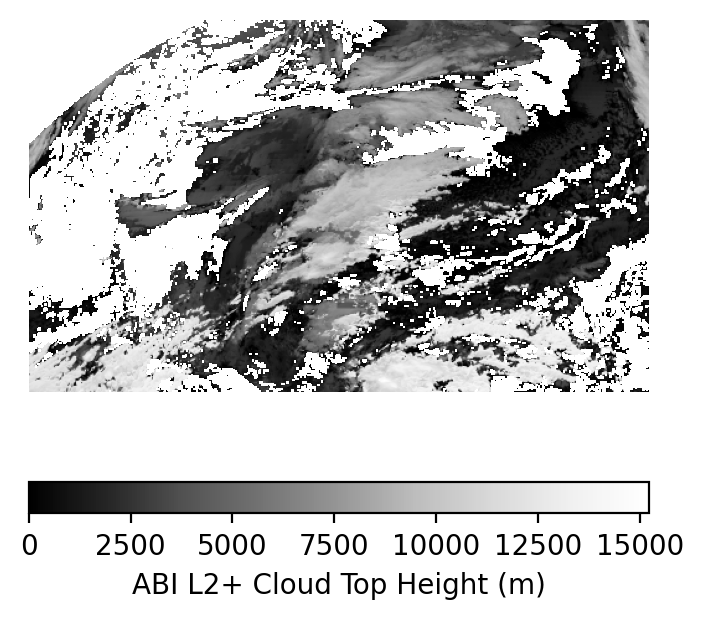

In [8]:
# Plot the variable to check if data loaded correctly
fig = plt.figure(figsize=(4,4),dpi=200)
im = plt.imshow(variable, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_label(var_name + ' ('+ units_name +')')
plt.axis('off')
plt.show()

In [9]:
# Write a path for the new GeoTIFF file
print ("\nConversion in progress...")
netCDF_file = xr.open_rasterio('netcdf:{0}:{1}'.format(path, var))
tiff_name = product_name + "_" + var + ".tif"
geotiff_pathname = os.path.join(directory + product_name +"_GeoTiffs", tiff_name)

# Execute the conversion from netCDF to GeoTIFF
netCDF_file.rio.to_raster(geotiff_pathname)
print("\n" + tiff_name + " has been generated")


Conversion in progress...

ABI-L2-ACHAC_HT.tif has been generated
